# Simulating Coatings of Keck II AO Bench

In this notebook we describe the procedure to try to back out the coatings used on the optics in the ORKID imaging path. This procedure makes the assumption that fitting the coating thickness to the reflectance curve is an accurate way of backing out the coating performance. We start by digging through the internal keck documents to determine what coatings exactly are used on all of the optics.



In [13]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from poke.thinfilms import compute_thin_films_broadcasted
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Opticoat Protected Al

In [14]:
pth = 'coatings/opticoat_alsio2_12deg.csv'
data = np.genfromtxt(pth,delimiter=',').T
spline = interp1d(data[0],data[1],kind='cubic')

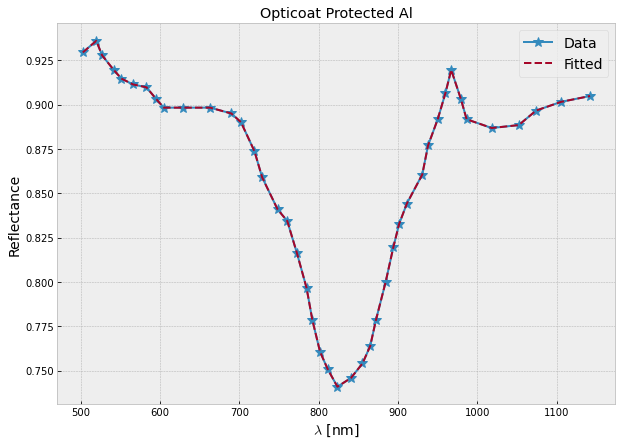

In [15]:
plt.figure(figsize=[10,7])
plt.title('Opticoat Protected Al')
plt.ylabel('Reflectance',fontsize=14)
plt.xlabel(r'$\lambda$'+' [nm]',fontsize=14)
plt.plot(data[0],data[1],label='Data',marker='*',markersize=10)
plt.plot(data[0],spline(data[0]),label='Fitted',linestyle='dashed')
plt.legend(fontsize=14)
plt.show()

### Load Materials

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


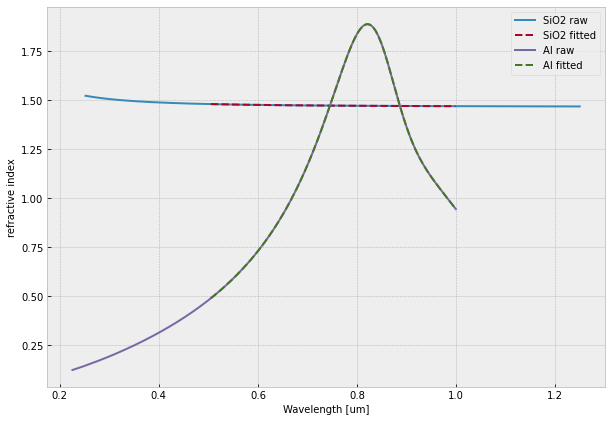

In [16]:
# set up wavelength range
wvl = np.arange(505,1000,1)

# create coating splines
pth_SiO2 = 'coatings/Gao_SiO2.csv'
dat_SiO2 = np.genfromtxt(pth_SiO2,delimiter=',',skip_header=1)[:500].T
n_SiO2 = interp1d(dat_SiO2[0],dat_SiO2[1])

# requires a little more because the index is complex
pth_Al = 'coatings/Cheng_Al.csv'
ndat_Al = np.genfromtxt(pth_Al,delimiter=',',skip_header=1)[:427].T
kdat_Al = np.genfromtxt(pth_Al,delimiter=',',skip_header=1)[429:].T
nd_Al = interp1d(ndat_Al[0],ndat_Al[1])
k_Al = interp1d(kdat_Al[0],kdat_Al[1])
n_Al = lambda wave: nd_Al(wave) + 1j*k_Al(wave)

plt.figure(figsize=[10,7])
plt.plot(dat_SiO2[0],dat_SiO2[1],label='SiO2 raw')
plt.plot(wvl*1e-3,n_SiO2(wvl*1e-3),label='SiO2 fitted',linestyle='dashed')
plt.plot(ndat_Al[0],ndat_Al[1],label='Al raw')
plt.plot(wvl*1e-3,n_Al(wvl*1e-3),label='Al fitted',linestyle='dashed')
plt.ylabel('refractive index')
plt.xlabel('Wavelength [um]')
plt.legend()
plt.show()

### Optimize a spline using SiO2 layer thickness as variable to get final solution

In [17]:
aoi = 12 # degrees for Opticoat measurements

def fit_coating(d):

    # build stack
    stack = [
        (n_SiO2(wvl*1e-3),d),
        (n_Al(wvl*1e-3))
    ]

    rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Al(wvl*1e-3))
    rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Al(wvl*1e-3),polarization='p')
    avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

    cost = np.sum((spline(wvl)-avg)**2)/avg.size # Mean squared error

    return cost

In [18]:
# dimensionality is low enough that we can just brute force the solution space
available = np.linspace(1e-2,1,1000)*1e3
cost = []
for d in available:
    cost.append(fit_coating(d))

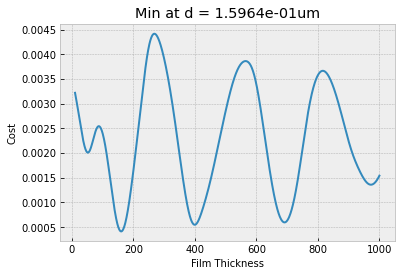

0.0004146363658935399


In [19]:
d_min = available[np.where(cost==np.min(cost))]
plt.figure()
plt.ylabel('Cost')
plt.xlabel('Film Thickness')
plt.title(f'Min at d = {d_min[0]*1e-3:0.4e}um')
plt.plot(available,cost)
plt.show()
print(np.min(cost))

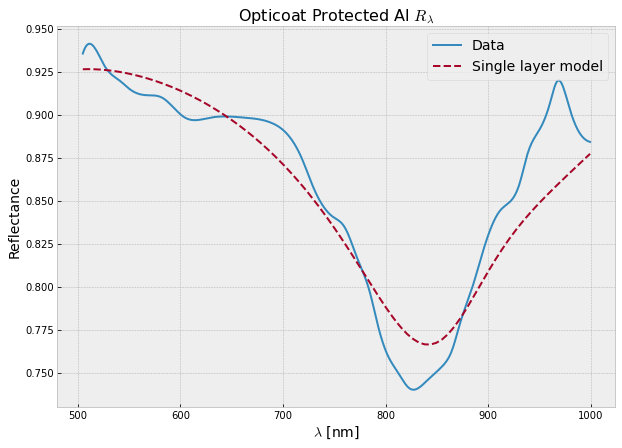

In [20]:
# build stack
stack = [
    (n_SiO2(wvl*1e-3),d_min),
    (n_Al(wvl*1e-3))
]

rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Al(wvl*1e-3))
rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Al(wvl*1e-3),polarization='p')
avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

plt.figure(figsize=[10,7])
plt.title('Opticoat Protected Al'+r' $R_{\lambda}$',fontsize=16)
plt.plot(wvl,spline(wvl),label='Data')
plt.plot(wvl,avg,label='Single layer model',linestyle='dashed')
plt.legend(fontsize=14)
plt.ylabel('Reflectance',fontsize=14)
plt.xlabel(r'$\lambda$'+' [nm]',fontsize=14)
plt.show()

## Opticoat Protected Ag

In [21]:
pth = 'coatings/opticoat_protag_12deg.csv'
data = np.genfromtxt(pth,delimiter=',').T
spline = interp1d(data[0],data[1],kind='linear')

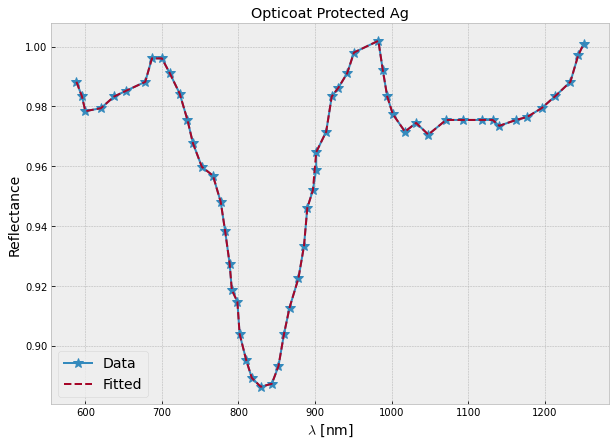

In [22]:
plt.figure(figsize=[10,7])
plt.title('Opticoat Protected Ag')
plt.ylabel('Reflectance',fontsize=14)
plt.xlabel(r'$\lambda$'+' [nm]',fontsize=14)
plt.plot(data[0],data[1],label='Data',marker='*',markersize=10)
plt.plot(data[0],spline(data[0]),label='Fitted',linestyle='dashed')
plt.legend(fontsize=14)
plt.show()

### Now we load the constituent materials, there are many more because we don't actually know what the silver is protected with

In [23]:
aoi = 12
wvl = np.arange(589,1000,1)

# create coating splines
pth_SiN = 'coatings/Philipp_SiN.csv'
dat_SiN = np.genfromtxt(pth_SiN,delimiter=',',skip_header=1)[:500].T
n_SiN = interp1d(dat_SiN[0],dat_SiN[1])

pth_MgF2 = 'coatings/Rodriguez-de Marcos_MgF2.csv'
dat_MgF2 = np.genfromtxt(pth_MgF2,delimiter=',',skip_header=1)[:962].T
kdat_MgF2 = np.genfromtxt(pth_MgF2,delimiter=',',skip_header=1)[964:].T
nd_MgF2 = interp1d(dat_MgF2[0],dat_MgF2[1])
k_MgF2 = interp1d(kdat_MgF2[0],kdat_MgF2[1])
n_MgF2 = lambda wave: nd_MgF2(wave) + 1j*k_MgF2(wave)

pth_SiO2 = 'coatings/Gao_SiO2.csv'
dat_SiO2 = np.genfromtxt(pth_SiO2,delimiter=',',skip_header=1)[:500].T
n_SiO2 = interp1d(dat_SiO2[0],dat_SiO2[1])

pth_Ag = 'coatings/Johnson_Ag.csv'
ndat_Ag = np.genfromtxt(pth_Ag,delimiter=',',skip_header=1)[:50].T
kdat_Ag = np.genfromtxt(pth_Ag,delimiter=',',skip_header=1)[52:].T
nd_Ag = interp1d(ndat_Ag[0],ndat_Ag[1])
k_Ag = interp1d(kdat_Ag[0],kdat_Ag[1])
n_Ag = lambda wave: nd_Ag(wave) + 1j*k_Ag(wave)

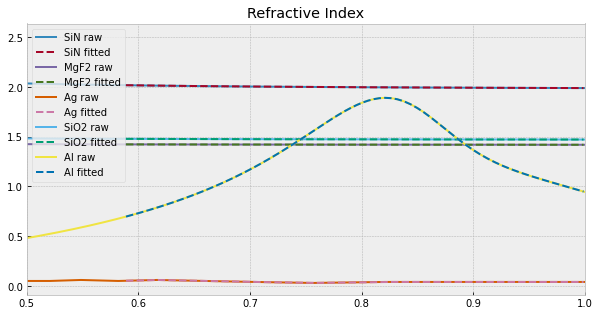

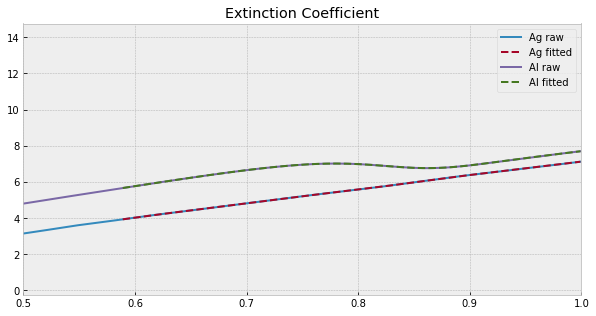

In [24]:

# Plot the index data
plt.figure(figsize=[10,5])
plt.title('Refractive Index')
plt.plot(dat_SiN[0],dat_SiN[1],label='SiN raw')
plt.plot(wvl*1e-3,n_SiN(wvl*1e-3),label='SiN fitted',linestyle='dashed')

plt.plot(dat_MgF2[0],dat_MgF2[1],label='MgF2 raw')
plt.plot(wvl*1e-3,n_MgF2(wvl*1e-3),label='MgF2 fitted',linestyle='dashed')

plt.plot(ndat_Ag[0],ndat_Ag[1],label='Ag raw')
plt.plot(wvl*1e-3,np.real(n_Ag(wvl*1e-3)),label='Ag fitted',linestyle='dashed')

plt.plot(dat_SiO2[0],dat_SiO2[1],label='SiO2 raw')
plt.plot(wvl*1e-3,n_SiO2(wvl*1e-3),label='SiO2 fitted',linestyle='dashed')

plt.plot(ndat_Al[0],ndat_Al[1],label='Al raw')
plt.plot(wvl*1e-3,n_Al(wvl*1e-3),label='Al fitted',linestyle='dashed')
plt.legend()
plt.xlim([0.5,1])
plt.show()

plt.figure(figsize=[10,5])
plt.title('Extinction Coefficient')
plt.plot(kdat_Ag[0],kdat_Ag[1],label='Ag raw')
plt.plot(wvl*1e-3,np.imag(n_Ag(wvl*1e-3)),label='Ag fitted',linestyle='dashed')
plt.plot(kdat_Al[0],kdat_Al[1],label='Al raw')
plt.plot(wvl*1e-3,np.imag(n_Al(wvl*1e-3)),label='Al fitted',linestyle='dashed')
plt.legend()
plt.xlim([0.5,1])
plt.show()

### Optimize a spline using layer thickness as variable to get final solution
Here we try a couple of materials to see which fits best
- SiN
- SiO2
- MgF2

In [25]:
def fit_coating_SiN(d):

    # build stack
    stack = [
        (n_SiN(wvl*1e-3),d),
        (n_Ag(wvl*1e-3))
    ]

    rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3))
    rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3),polarization='p')
    avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

    cost = np.sum((spline(wvl)-avg)**2)/avg.size

    return cost

def fit_coating_SiO2(d):

    # build stack
    stack = [
        (n_SiO2(wvl*1e-3),d),
        (n_Ag(wvl*1e-3))
    ]

    rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3))
    rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3),polarization='p')
    avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

    cost = np.sum((spline(wvl)-avg)**2)/avg.size

    return cost

def fit_coating_MgF2(d):

    # build stack
    stack = [
        (n_MgF2(wvl*1e-3),d),
        (n_Ag(wvl*1e-3))
    ]

    rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3))
    rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3),polarization='p')
    avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

    cost = np.sum((spline(wvl)-avg)**2)/avg.size

    return cost

In [26]:
# dimensionality is low enough that we can just brute force the solution space
available = np.linspace(1e-2,3,1000)*1e3
cost_SiN = []
cost_SiO2 = []
cost_MgF2 = []
for d in available:
    cost_SiN.append(fit_coating_SiN(d))
    cost_SiO2.append(fit_coating_SiO2(d))
    cost_MgF2.append(fit_coating_MgF2(d))

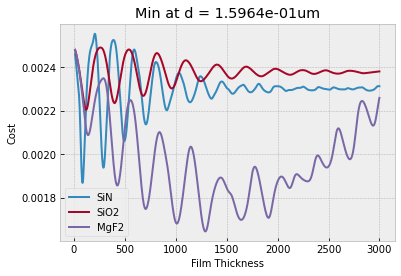

SiN min cost =  0.0018694643464388877
SiO2 min cost =  0.0022048638183553688
MgF2 min cost =  0.0016464844358473102


In [27]:
plt.figure()
plt.ylabel('Cost')
plt.xlabel('Film Thickness')
plt.title(f'Min at d = {d_min[0]*1e-3:0.4e}um')
plt.plot(available,cost_SiN,label='SiN')
plt.plot(available,cost_SiO2,label='SiO2')
plt.plot(available,cost_MgF2,label='MgF2')
plt.legend()
plt.show()


print('SiN min cost = ',np.min(cost_SiN))
print('SiO2 min cost = ',np.min(cost_SiO2))
print('MgF2 min cost = ',np.min(cost_MgF2))

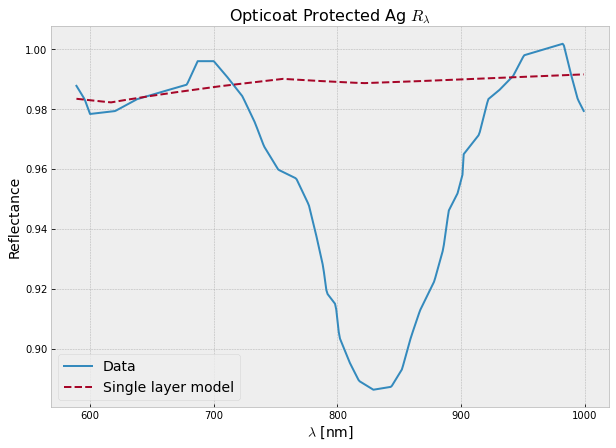

In [28]:
# MgF2 is the winner!
dmin = available[np.where(cost_MgF2==np.min(cost_MgF2))]

# build stack
stack = [
    (n_MgF2(wvl*1e-3),d_min),
    (n_Ag(wvl*1e-3))
]

rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3))
rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3),polarization='p')
avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

plt.figure(figsize=[10,7])
plt.title('Opticoat Protected Ag'+r' $R_{\lambda}$',fontsize=16)
plt.plot(wvl,spline(wvl),label='Data')
plt.plot(wvl,avg,label='Single layer model',linestyle='dashed')
plt.legend(fontsize=14)
plt.ylabel('Reflectance',fontsize=14)
plt.xlabel(r'$\lambda$'+' [nm]',fontsize=14)
plt.show()

## Denton FSS-99
This will use very similar materials to the above coating, so we don't need to go through the material loading step

In [29]:
pth = 'coatings/dentonfss99.csv'
data = np.genfromtxt(pth,delimiter=',').T
spline = interp1d(data[0],data[1]/100,kind='linear')

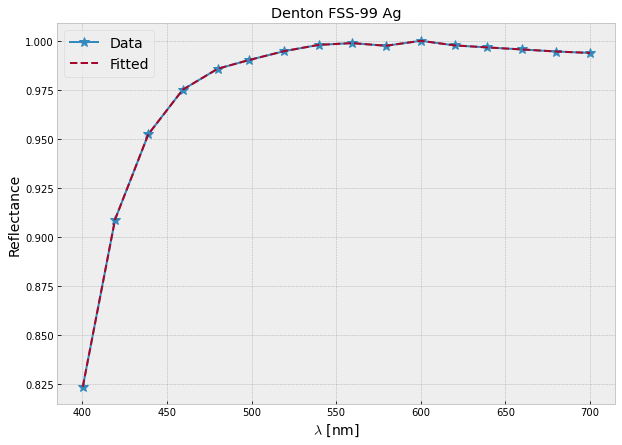

In [30]:
plt.figure(figsize=[10,7])
plt.title('Denton FSS-99 Ag')
plt.ylabel('Reflectance',fontsize=14)
plt.xlabel(r'$\lambda$'+' [nm]',fontsize=14)
plt.plot(data[0],data[1]/100,label='Data',marker='*',markersize=10)
plt.plot(data[0],spline(data[0]),label='Fitted',linestyle='dashed')
plt.legend(fontsize=14)
plt.show()

In [31]:
# We do need to redefine our cost functions for zero angle of incidence and a new wavelength range
aoi = 0
wvl = np.arange(401,700,1)

def fit_coating_SiN(d):

    # build stack
    stack = [
        (n_SiN(wvl*1e-3),d),
        (n_Ag(wvl*1e-3))
    ]

    rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3))
    rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3),polarization='p')
    avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

    cost = np.sum((spline(wvl)-avg)**2)/avg.size

    return cost

def fit_coating_SiO2(d):

    # build stack
    stack = [
        (n_SiO2(wvl*1e-3),d),
        (n_Ag(wvl*1e-3))
    ]

    rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3))
    rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3),polarization='p')
    avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

    cost = np.sum((spline(wvl)-avg)**2)/avg.size

    return cost

def fit_coating_MgF2(d):

    # build stack
    stack = [
        (n_MgF2(wvl*1e-3),d),
        (n_Ag(wvl*1e-3))
    ]

    rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3))
    rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3),polarization='p')
    avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

    cost = np.sum((spline(wvl)-avg)**2)/avg.size

    return cost

In [32]:
# dimensionality is low enough that we can just brute force the solution space
available = np.linspace(1e-2,3,1000)*1e3
cost_SiN = []
cost_SiO2 = []
cost_MgF2 = []
for d in available:
    cost_SiN.append(fit_coating_SiN(d))
    cost_SiO2.append(fit_coating_SiO2(d))
    cost_MgF2.append(fit_coating_MgF2(d))

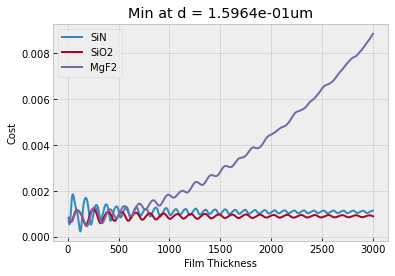

SiN min cost =  0.0002477689506477541
SiO2 min cost =  0.0005198832792502873
MgF2 min cost =  0.0004709502306394341


In [33]:
plt.figure()
plt.ylabel('Cost')
plt.xlabel('Film Thickness')
plt.title(f'Min at d = {d_min[0]*1e-3:0.4e}um')
plt.plot(available,cost_SiN,label='SiN')
plt.plot(available,cost_SiO2,label='SiO2')
plt.plot(available,cost_MgF2,label='MgF2')
plt.legend()
plt.show()
print('SiN min cost = ',np.min(cost_SiN))
print('SiO2 min cost = ',np.min(cost_SiO2))
print('MgF2 min cost = ',np.min(cost_MgF2))

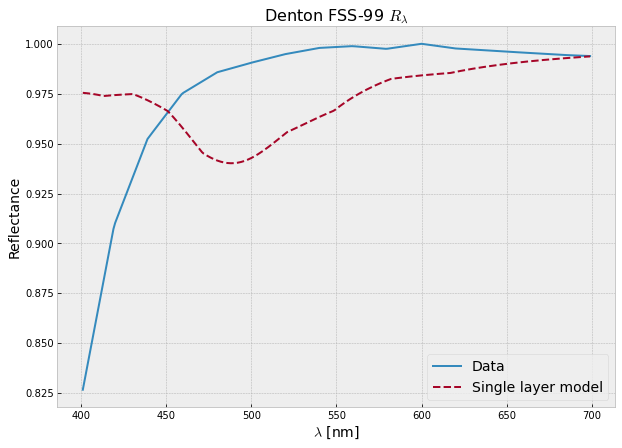

In [35]:
# SiN is the winner
dmin = available[np.where(cost_SiN==np.min(cost_SiN))]

# build stack
stack = [
    (n_SiN(wvl*1e-3),d_min),
    (n_Ag(wvl*1e-3))
]

rs,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3))
rp,_ = compute_thin_films_broadcasted(stack,np.full_like(wvl,np.radians(aoi)),wvl,substrate_index=n_Ag(wvl*1e-3),polarization='p')
avg = (np.abs(rs)**2 + np.abs(rp)**2)/2

plt.figure(figsize=[10,7])
plt.title('Denton FSS-99'+r' $R_{\lambda}$',fontsize=16)
plt.plot(wvl,spline(wvl),label='Data')
plt.plot(wvl,avg,label='Single layer model',linestyle='dashed')
plt.legend(fontsize=14)
plt.ylabel('Reflectance',fontsize=14)
plt.xlabel(r'$\lambda$'+' [nm]',fontsize=14)
plt.show()